In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from iminuit import Minuit   
from scipy import stats
from scipy.stats import linregress
import sys
from astropy.wcs import WCS
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
import Annas_functions as func
sys.path.append(r'C:\Users\anna_\OneDrive\Υπολογιστής\MSc\AppStats\AppStat2023\External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax
from spectral_cube import SpectralCube
import astropy.units as u
import yt
import pyvista as pv
import matplotlib
import matplotlib.patches as patches

font = {'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rcParams['axes.formatter.useoffset']= False

## Read cube data (intensity)

In [27]:
hdulist=fits.open(r'C:\Users\anna_\OneDrive\Υπολογιστής\MSc\Thesis\data\i16293\Combined\tune_a\IRAS_16293-2422_a.spw16.fits')
spectrum=hdulist[0].data[0,:,0,0]
header=hdulist[0].header

dec = hdulist[0].data[0:250,:,0]
ra = hdulist[0].data[0:250,0,:]
int_data = hdulist[0].data[0:250,:,:]
cube = SpectralCube.read(hdulist)
print(cube)

SpectralCube with shape=(1018, 160, 160) and unit=Jy / beam:
 n_x:    160  type_x: RA---SIN  unit_x: deg    range:   248.058490 deg:  248.131301 deg
 n_y:    160  type_y: DEC--SIN  unit_y: deg    range:   -24.509523 deg:  -24.443273 deg
 n_s:   1018  type_s: FREQ      unit_s: Hz     range: 110333817842.200 Hz:110395916269.009 Hz


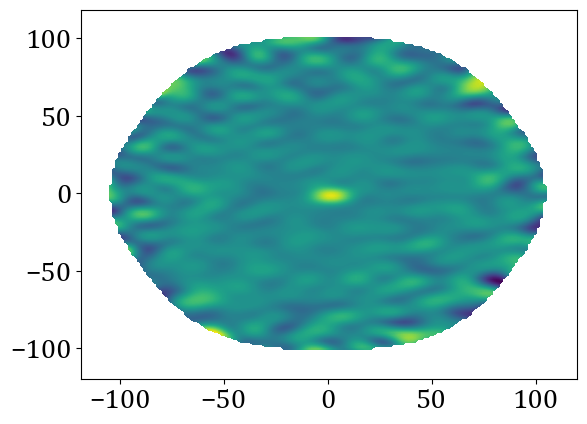

In [29]:
data=hdulist[0].data
header=hdulist[0].header
spectrum=hdulist[0].data[:,0,0,:]

xaxis=(np.arange(header['NAXIS1'])-(header['CRPIX1']-1))*header['CDELT1']*60.0**2
yaxis=(np.arange(header['NAXIS2'])-(header['CRPIX2']-1))*header['CDELT2']*60.0**2

plt.figure(1)

slice_data = data[0,250, :, :]

plt.contourf(xaxis, yaxis, slice_data, 250, alpha=1)
# print(header)

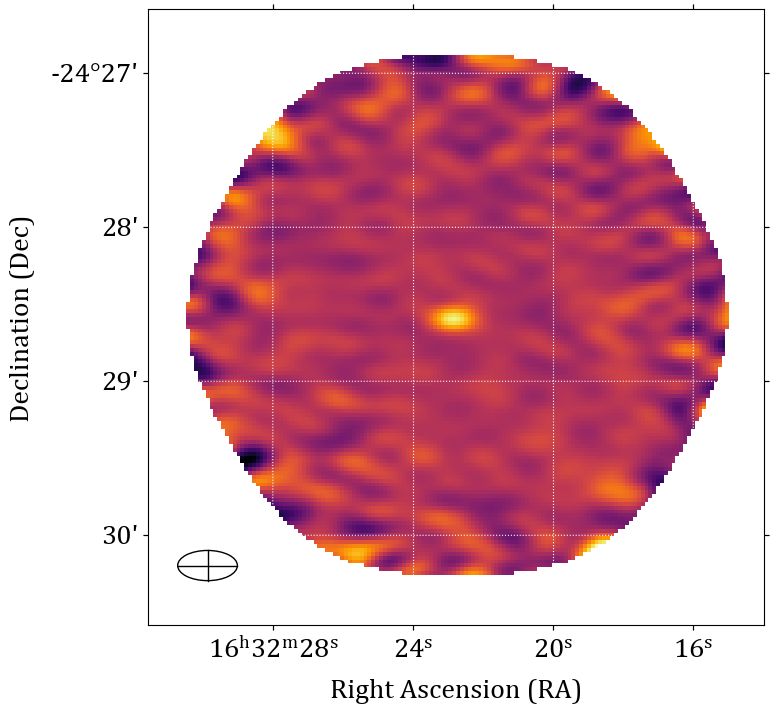

In [31]:
# Extract WCS information
wcs = WCS(header, naxis=2)

# Define the full image region
naxis1 = header['NAXIS1']  # Full image width (RA)
naxis2 = header['NAXIS2']  # Full image height (Dec)

# Plot the full image with WCS projection
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Cambria'
plt.rcParams['font.size'] = 20

# Display the full image using imshow
im = ax.imshow(slice_data, origin='lower', cmap='inferno')

# Add gridlines for the WCS coordinates
ax.coords.grid(True, color='white', ls='dotted')

# Set labels for RA and Dec
ax.set_xlabel('Right Ascension (RA)')
ax.set_ylabel('Declination (Dec)')

beam_size_major_arcsec = header['BMAJ']*3600  # Major axis size in arcseconds
beam_size_minor_arcsec = header['BMIN']*3600   # Minor axis size in arcseconds
# Convert arcseconds to pixels (depends on your data; adjust accordingly)
pixels_per_arcsec = 1.0  # Replace this with the pixel scale from your WCS
beam_size_major_pixels = beam_size_major_arcsec * pixels_per_arcsec
beam_size_minor_pixels = beam_size_minor_arcsec * pixels_per_arcsec

# Create an ellipse representing the beam size
beam_ellipse_1 = patches.Ellipse((15, 15),  # Center position (in axis fraction)
                                beam_size_major_pixels,  # Width of ellipse
                                beam_size_minor_pixels,  # Height of ellipse
                                edgecolor='black', facecolor='none', linewidth=1, angle=0)  # Angle can be adjusted

ax.add_patch(beam_ellipse_1)

plt.plot([15 - beam_size_major_pixels / 2, 15 + beam_size_major_pixels / 2], [15, 15], color='black', linewidth=1)  # Major axis
plt.plot([15, 15], [15 - beam_size_minor_pixels / 2, 15 + beam_size_minor_pixels / 2], color='black', linewidth=1)  # Minor axis
# plt.colorbar(im, label='Intensity (Jy/beam)')
# plt.xlim(50,105)
# plt.ylim(50,105)
# plt.savefig(r"C:\Users\anna_\OneDrive\Υπολογιστής\MSc\Thesis\results\example data one.pdf", dpi=200, bbox_inches='tight')

In [2]:
# Read the FITS file
cube = r'C:\Users\anna_\OneDrive\Υπολογιστής\MSc\Thesis\data\i16293\Combined\tune_a\IRAS_16293-2422_a.spw20.fits'
hdul = fits.open(cube)

# Extract the data from the first extension (usually where the main data is stored)
data = hdul[0].data

# Close the FITS file
hdul.close()

# Inspect the shape of the data (e.g., 3D array)
data = np.squeeze(data)

factor = 10  # You can experiment with this value to reduce resolution

data_downsampled = data[::factor, ::factor, ::factor]
nz, ny, nx = data_downsampled.shape

# Create a PyVista grid with the same shape as your data
grid = pv.StructuredGrid()

grid.dimensions = (nx, ny, nz)

# Create the coordinate grid based on the dimensions
x, y, z = np.meshgrid(np.arange(nx), np.arange(ny), np.arange(nz), indexing='ij')

# Flatten the coordinate arrays for PyVista
coordinates = np.vstack((x.flatten(), y.flatten(), z.flatten())).T

# Set the coordinates of the grid
grid.points = coordinates

grid.point_data['data'] = data_downsampled.flatten(order='F')  # 'F' for Fortran-like column-major order

# Visualize the grid with a volume plot
plotter = pv.Plotter()

# Add the volume to the plot with a chosen color map (e.g., 'inferno')
plotter.add_volume(grid, cmap='inferno')

# Show the interactive plot
plotter.show()

Widget(value='<iframe src="http://localhost:58832/index.html?ui=P_0x21c747f82d0_0&reconnect=auto" class="pyvis…

## Read cube data (spectrum)

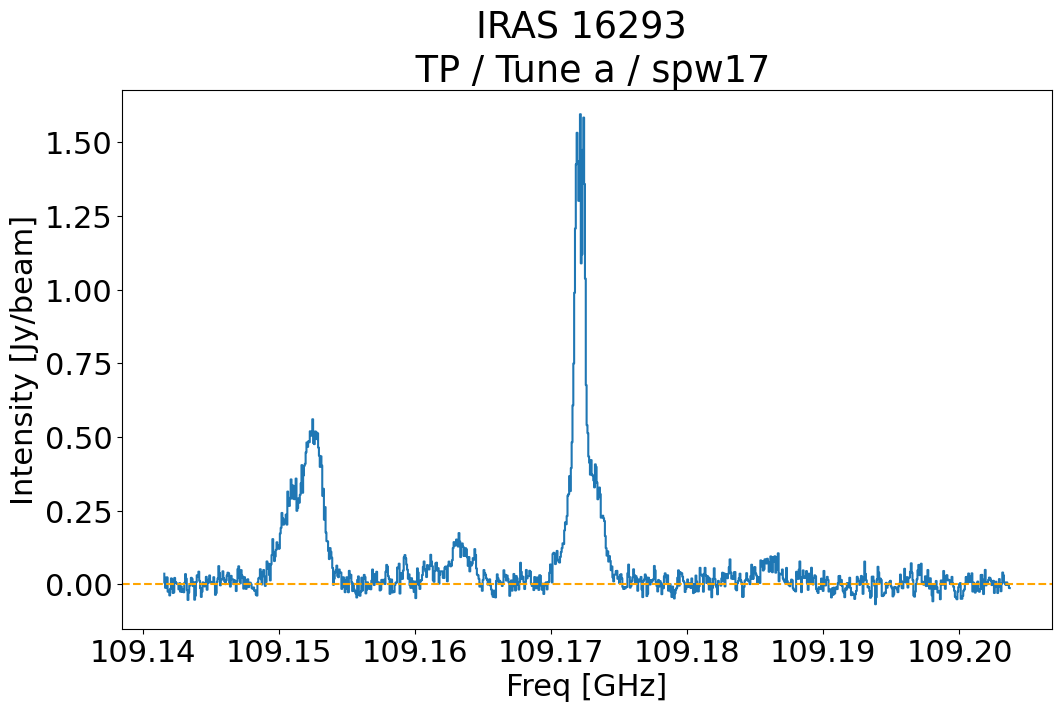

109.14159572739999 109.20369384910619


In [5]:
data2=hdulist[0].data
header2=hdulist[0].header
xaxis2=(np.arange(header2['NAXIS1'])-(header2['CRPIX1']-1))*header2['CDELT1']*60.0**2
yaxis2=(np.arange(header2['NAXIS2'])-(header2['CRPIX2']-1))*header2['CDELT2']*60.0**2
vaxis2=(np.arange(header2['NAXIS3'])-(header2['CRPIX3']-1))*header2['CDELT3']/1000.0+header2['CRVAL3']/1000.0
X2, Y2 = np.meshgrid(xaxis2, yaxis2)

plt.figure(figsize=(12,7))
plt.step(vaxis2/1.e6,data2[0,:,79,79])
plt.axhline(y=0,linestyle='--', c='orange')

plt.title('IRAS 16293 \n TP / Tune a / spw17')
plt.xlabel('Freq [GHz]')
plt.ylabel('Intensity [Jy/beam]')
# plt.xlim(230.538, 230.543)
plt.show()
print(np.min(vaxis2/1.e6), np.max(vaxis2/1.e6))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


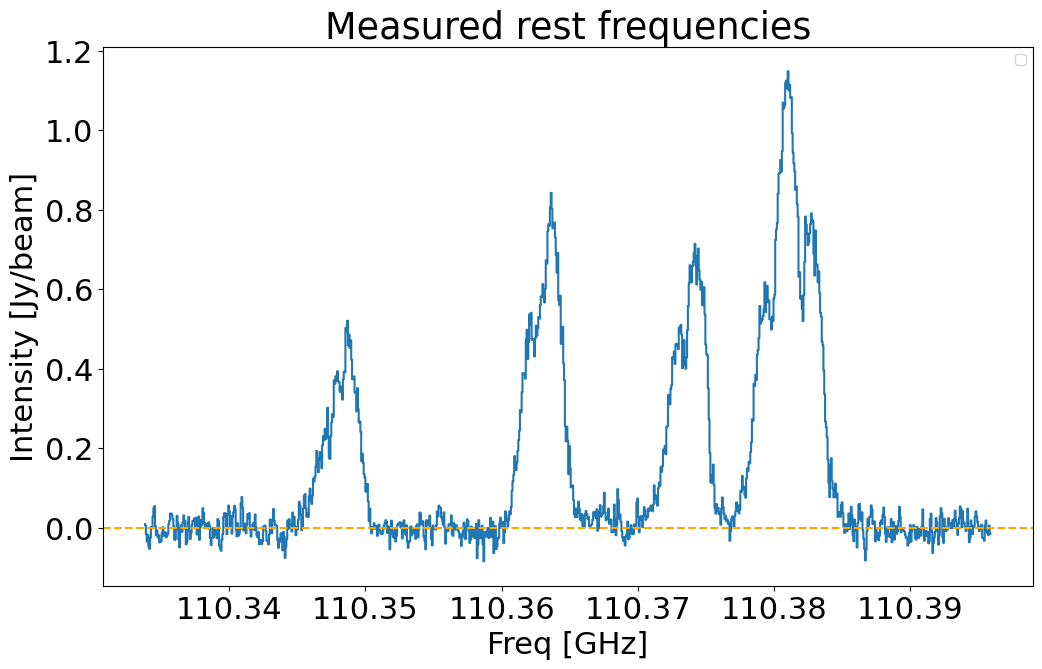

In [7]:
plt.figure(figsize=(12,7))
plt.step(vaxis2/1.e6,data2[0,:,79,79])
plt.axhline(y=0,linestyle='--', c='orange')

# plt.axvline(x=95.94734, linestyle='--', c='cyan', label='$CH_3CHO, v_t=0, 5(0,5)-4(0,4)E$')
# plt.axvline(x=95.94734, linestyle='--', c='cyan', label='$LogA_{ij}=-4.52944, E_U(K)=13.93514$')

# plt.axvline(x=109.7821734, linestyle='--', c='red', linewidth=1, label='$C^{18}O, J=1-0$')
# plt.axvline(x=110.2013218, linestyle='--', c='red', label='$LogA_{ij}=-4.52952, E_U(K)=13.83807$')

# plt.axvline(x=109.153184, linestyle='--', c='limegreen', linewidth=1, label='$CH_3OH,	16(2,14)-16(-1,15)E, vt=0$')
# plt.axvline(x=95.967833, linestyle='--', c='limegreen', label='$LogA_{ij}=-5.35324, E_U(K)=147.0625$')

# plt.axvline(x=109.7575851, linestyle='--', c='indigo', linewidth=1, label='$SO_2, 17(5,13)-18(4,14)$')
# plt.axvline(x=96.75551, linestyle='--', c='indigo', label='$LogA_{ij}=-5.58107, E_U(K)=28.01055$')

# plt.axvline(x=94.420449, linestyle='--', c='darkorange', label='$CH_3CN, 6(0)-5(0)$')
# plt.axvline(x=110.383494, linestyle='--', c='darkorange', label='$LogA_{ij}=-3.95612, E_U(K)=18.54141$')

plt.xlabel('Freq [GHz]')
plt.ylabel('Intensity [Jy/beam]')

plt.title('Measured rest frequencies')
plt.legend(fontsize='10', loc='best')
# plt.savefig(r'C:\Users\anna_\OneDrive\Υπολογιστής\MSc\Thesis\results\spectral lines\i16293\7m\tune a\spw20 cdms.pdf', dpi=200)

## Identified lines in the spectrum plot

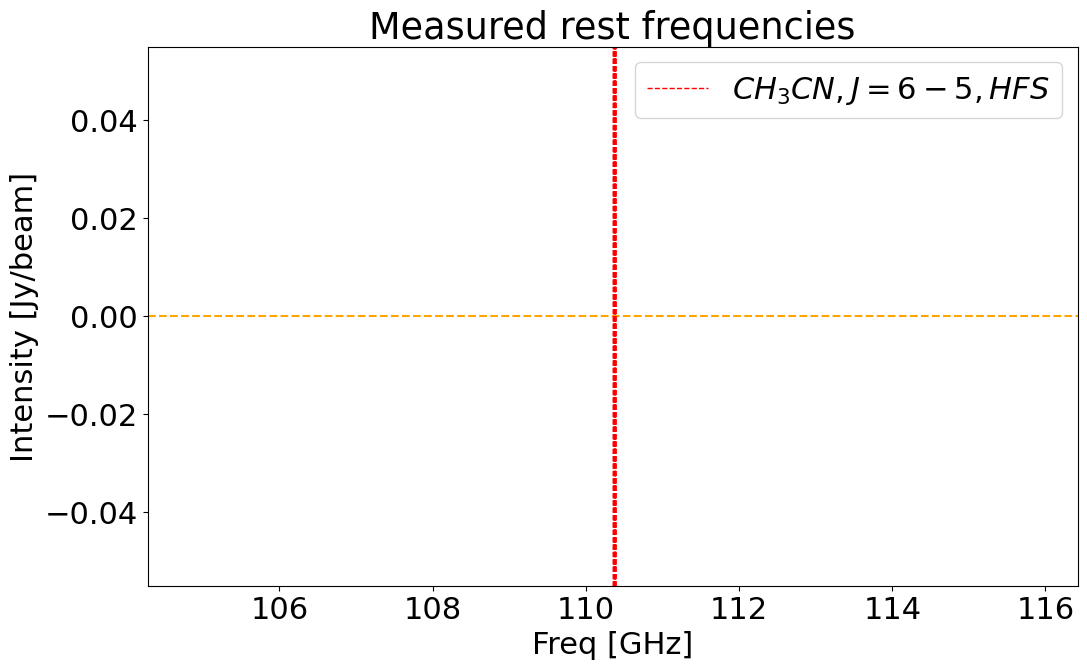

In [8]:
plt.figure(figsize=(12,7))
plt.step(vaxis2/1.e6,data2[0,:,25,23])
plt.axhline(y=0,linestyle='--', c='orange')

x = np.array([110.3489884,
110.3496554,
110.3497944,
110.3640856,
110.3640856,
110.3644659,
110.3644659,
110.3645205,
110.3645205,
110.3739819,
110.3748678,
110.3750466,
110.3750466,
110.3760898,
110.3800154,
110.3813425,
110.3813612,
110.3814009,
110.382029,
110.3829338,
110.3834661,
110.3834999,
110.3835183,
110.3852149
])

plt.axvline(x[0], c='red', linestyle='--', linewidth=1, label='$CH_3CN, J=6-5, HFS$')
plt.axvline(x[1], c='red', linestyle='--', linewidth=1)
plt.axvline(x[2], c='red', linestyle='--', linewidth=1)
plt.axvline(x[3], c='red', linestyle='--', linewidth=1)
plt.axvline(x[4], c='red', linestyle='--', linewidth=1)
plt.axvline(x[5], c='red', linestyle='--', linewidth=1)
plt.axvline(x[6], c='red', linestyle='--', linewidth=1)
plt.axvline(x[7], c='red', linestyle='--', linewidth=1)
plt.axvline(x[8], c='red', linestyle='--', linewidth=1)
plt.axvline(x[9], c='red', linestyle='--', linewidth=1)
plt.axvline(x[10], c='red', linestyle='--', linewidth=1)
plt.axvline(x[11], c='red', linestyle='--', linewidth=1)
plt.axvline(x[12], c='red', linestyle='--', linewidth=1)
plt.axvline(x[13], c='red', linestyle='--', linewidth=1)
plt.axvline(x[14], c='red', linestyle='--', linewidth=1)
plt.axvline(x[15], c='red', linestyle='--', linewidth=1)
plt.axvline(x[16], c='red', linestyle='--', linewidth=1)
plt.axvline(x[17], c='red', linestyle='--', linewidth=1)
plt.axvline(x[18], c='red', linestyle='--', linewidth=1)
plt.axvline(x[19], c='red', linestyle='--', linewidth=1)

plt.xlabel('Freq [GHz]')
plt.ylabel('Intensity [Jy/beam]')

plt.title('Measured rest frequencies')
plt.legend()
# plt.savefig(r'C:\Users\anna_\OneDrive\Υπολογιστής\MSc\Thesis\results\spectral lines\i16293\7m\tune b\spw24 cdms.pdf', dpi=200)

## Redshifted spectrum and lines

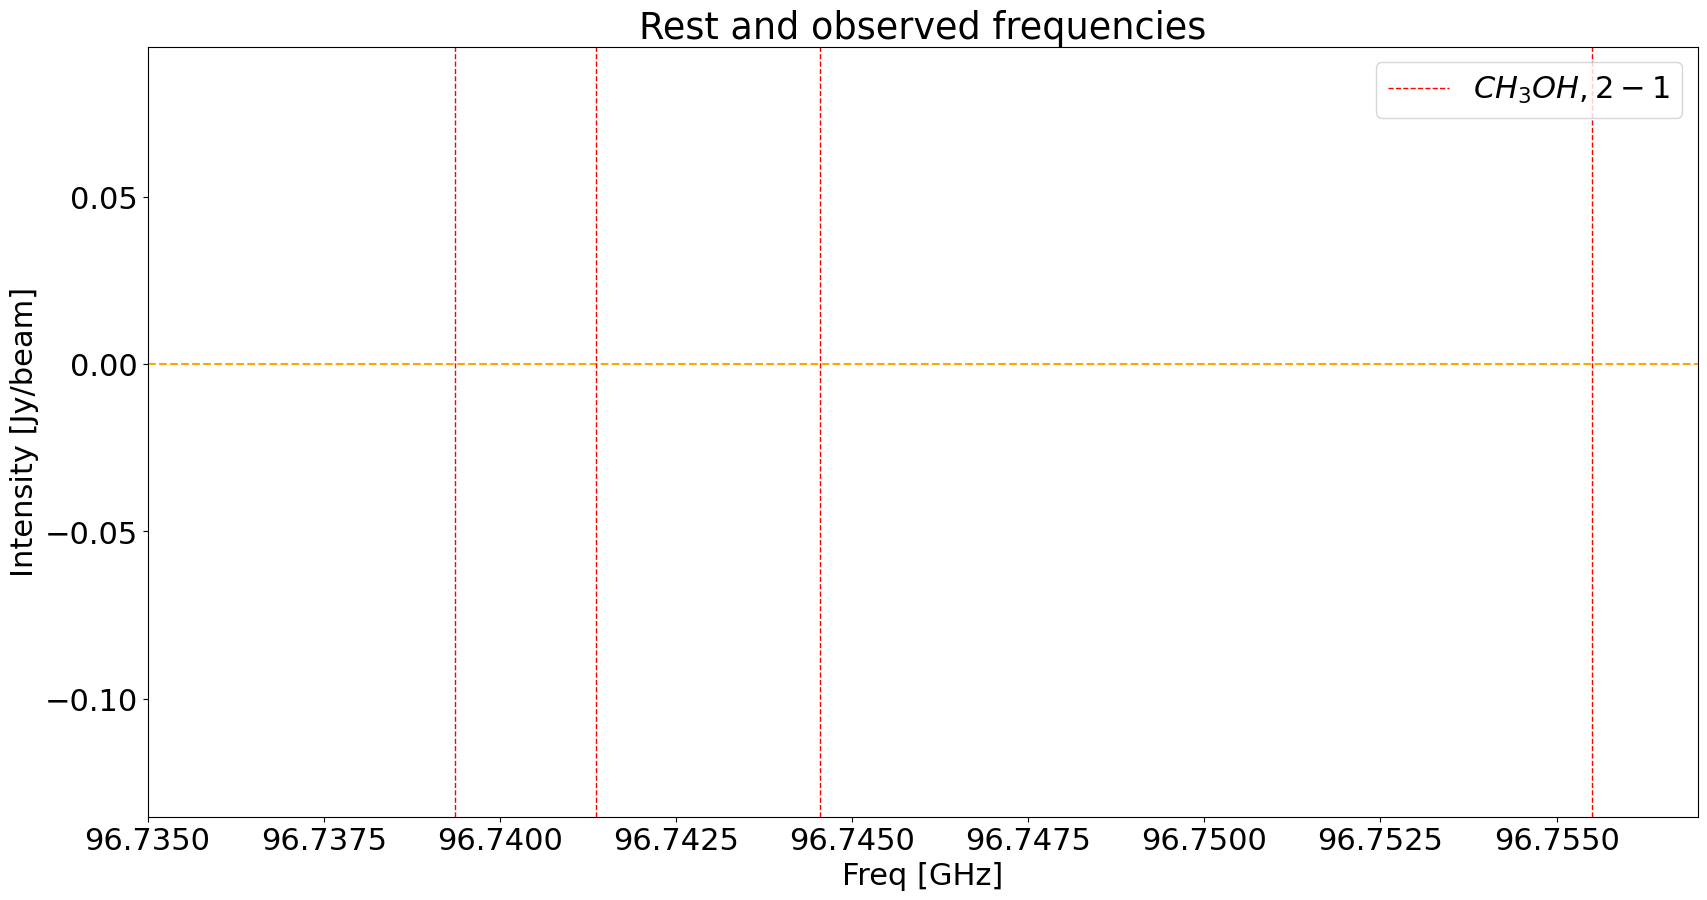

In [9]:
shift = 0.00216 #redshift in GHZ

plt.figure(figsize=(20,10))
plt.step(vaxis2/1.e6 + shift, data2[0,:,86,58])
plt.axhline(y=0,linestyle='--', c='orange')

x = np.array([96.739358,
96.741371,
96.744545,
96.755501
])

plt.axvline(x[0], c='red', linestyle='--', linewidth=1, label='$CH_3OH, 2-1$')
plt.axvline(x[1], c='red', linestyle='--', linewidth=1)
plt.axvline(x[2], c='red', linestyle='--', linewidth=1)
plt.axvline(x[3], c='red', linestyle='--', linewidth=1)

red_x = x - shift

# plt.axvline(red_x[0], c='green', linestyle='--', linewidth=1, label='$corrected$')
# plt.axvline(red_x[1], c='green', linestyle='--', linewidth=1)
# plt.axvline(red_x[2], c='green', linestyle='--', linewidth=1)
# plt.axvline(red_x[3], c='green', linestyle='--', linewidth=1)


plt.xlabel('Freq [GHz]')
plt.ylabel('Intensity [Jy/beam]')

plt.xlim(96.735, 96.757)

plt.title('Rest and observed frequencies')
plt.legend()

# plt.savefig(r'C:\Users\anna_\OneDrive\Υπολογιστής\MSc\Thesis\results\spectral lines\i16293\7m\tune b\spw24 corrected.pdf', dpi=200)